### Application of the LBM and LRR algorithms on and image sequence  
In this notebook, we will apply the Latice Boltzman Method (LBM) coupled with the Low Rank Representation : GoDec (LRR) on an image sequence to get the velocity field of the sequence

In [1]:
# Import the functiond from the .py files
from flowAlgorithm import flow_algorithm
from goDec import GoDec

# Import the libraries
import skimage.io as io
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt

In [2]:
# Define the path to the images or the video

video_file_path = "./Resources/demo.mp4"
frames_save_path = "./Resources/frames"
frame_name_prefix = "frame_"

In [3]:
# Get the image sequence
if not os.path.exists(frames_save_path):
    os.makedirs(frames_save_path)
    # Start capturing the video
    video = cv2.VideoCapture(video_file_path)

    if not video.isOpened():
        print("Error: Could not open video.")
    else:
        frame_index = 0
        while True:
            ret, frame = video.read()
            # If the frame was not retrieved, we've reached the end of the video (or there's an error)
            if not ret:
                break

            # Construct the frame save path
            frame_save_path = os.path.join(frames_save_path, f"{frame_name_prefix}{frame_index}.jpg")
            
            # Save the frame
            cv2.imwrite(frame_save_path, frame)
            print(f"Saved {frame_save_path}")
            
            frame_index += 1

        # Release the video capture object
        video.release()
        print("Video processing complete.")

print("Importing the frames.")
# Extract the frames
nb_frames = len([name for name in os.listdir(frames_save_path) if os.path.isfile(os.path.join(frames_save_path, name))])
shape = io.imread(os.path.join(frames_save_path, f"{frame_name_prefix}0.jpg")).shape
video = np.zeros((nb_frames,shape[0],shape[1]))
for i in range(51):
    frame_save_path = os.path.join(frames_save_path, f"{frame_name_prefix}{i}.jpg")
    video[i,:,:] = io.imread(frame_save_path, as_gray=True)
print("Imported all the frames.")

Importing the frames.


Imported all the frames.


Now that we have all the frames, we can use the GoDec Algorithm. Given matrix X, the algorithm splits it in three matrices:
- L : matrix with rank r
- S : sparce matrix with exactly k elements
- W : the error matrix

In [4]:
# Chosing the parameters for GoDec
r = 2
k = 20*len(video) # Equivalent to 20 active pixels per frame
epsilon = 0.01
q = 3

L, S, W, error_history = GoDec(video,r,k,epsilon,q)


We can now show the different matrices that the functon outputed

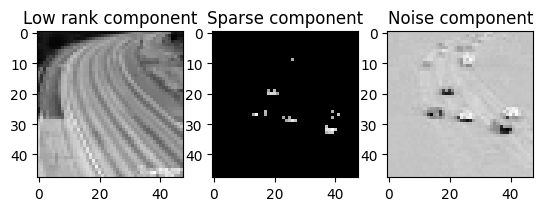

In [5]:
# chose which frame to display
frame = 10

plt.figure()
plt.subplot(1,3,1)
plt.imshow(L[frame,:,:],cmap='gray')
plt.title('Low rank component')
plt.subplot(1,3,2)
plt.imshow(S[frame,:,:],cmap='gray')
plt.title('Sparse component')
plt.subplot(1,3,3)
plt.imshow(W[frame,:,:],cmap='gray')
plt.title('Noise component')
plt.show()

Now we can apply the flow alrorithm on the sparse matrix S

In [6]:
# Define the parameters for the flow algorithm
rho = S  # Sparse component
N = 5  # Number of correction cycles
omega_fr = 0.1  # Relaxation frequency
omega_tilde = 0.1  # Correction rate
nbFrames = rho.shape[0]  # Number of frames in the video (put 1 if you have 2 frames)

# Apply the flow algorithm
velocity_field = flow_algorithm(rho, N, omega_fr, omega_tilde, nbFrames)

We can now visualize the result by ploting the magnitude of the output velocity field

In [17]:
# Frame to display
frame = 35

In [18]:
# Compute the speed magnitude of the velocity field at each pixel on each frame
speed_magnitude = np.zeros((nbFrames, rho.shape[1], rho.shape[2])) 
for t in range(nbFrames-1):
    for x in range(rho.shape[1]):
        for y in range(rho.shape[2]):
            speed_magnitude[t, x, y] = np.linalg.norm(velocity_field[t, x, y, :])

In [19]:
# Images are upside down, so we need to flip them
speed_magnitude_frame = speed_magnitude[frame, :, :]
speed_magnitude_frame = np.flipud(speed_magnitude_frame)
original_frame = np.flipud(video[frame, :, :])

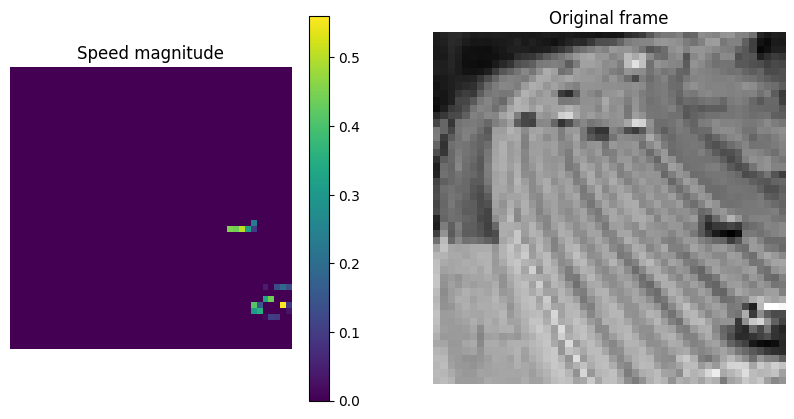

In [20]:
# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(speed_magnitude_frame, cmap='viridis', origin='lower')
plt.axis('off')

plt.imsave("speed_magnitude.png",speed_magnitude[frame, :, :], cmap='viridis', origin='lower')
plt.colorbar()
plt.title('Speed magnitude')
plt.subplot(1, 2, 2)
plt.imshow(original_frame, cmap='gray', origin='lower')
plt.axis('off')
plt.title('Original frame')
plt.show()

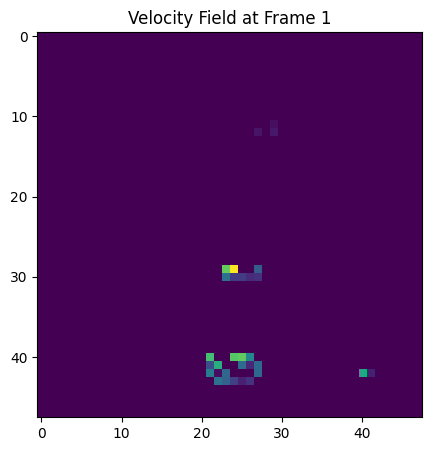

In [8]:
frame_index = 1
selected_frame = velocity_field[frame_index]

# Extract the x and y components of the velocity vectors
x_component = selected_frame[:, :, 0]
y_component = selected_frame[:, :, 1]

# Create a grid of coordinates for the quiver plot
image = np.sqrt(np.square(x_component)+np.square(y_component))

# Plot the vector field using quiver plot
plt.figure(figsize=(10, 5))
plt.imshow(image)
plt.title('Velocity Field at Frame {}'.format(frame_index))
plt.show()

In [9]:
for i in range(len(image)):
    for j in range(len(image[0])):
        if image[i,j] !=0:
            print(image[i,j])

2.3325048865896482e-17
0.028388813443072796
0.03685775460278423
0.04535876368770431
0.5329729057969501
0.6976082574775196
0.20594647795100632
0.26188698291538126
0.1229889563767388
0.12200470079868604
0.08965683129539054
0.09888039107786874
0.4898438044808839
0.5130522953621335
0.5275026725802189
0.3243622849022053
0.16657120853063065
0.4362874388645696
0.24335461697651428
0.08004445060655296
0.23715717281684454
0.29430088077060673
0.026092740719666784
0.23030280238044146
0.2330496575386317
0.41467117415890425
0.061439488641918415
0.26066002485068746
0.21849538300301385
0.13262788199868192
0.06362075670428351
0.10260071129391078
1.6167022361928892e-17


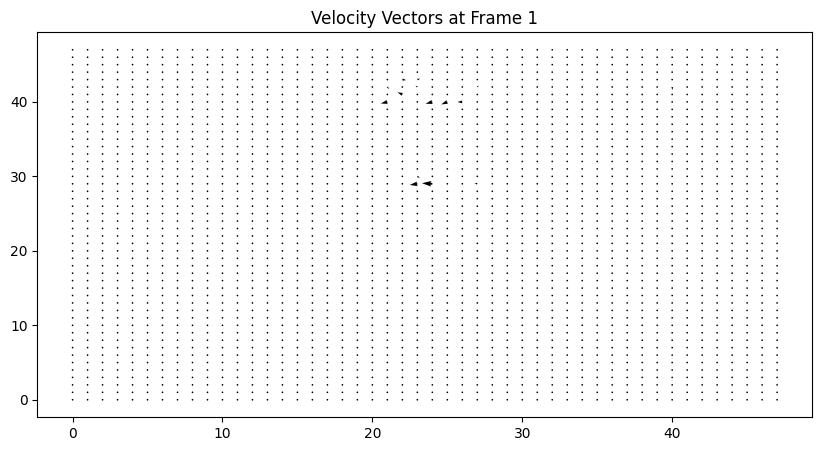

In [10]:
frame_index =1
selected_frame = velocity_field[frame_index]

# Extract the x and y components of the velocity vectors
x_component = selected_frame[:, :, 0]
y_component = selected_frame[:, :, 1]

# Create a grid of coordinates for the quiver plot
x, y = np.meshgrid(np.arange(selected_frame.shape[1]), np.arange(selected_frame.shape[0]))

# Plot the velocity vectors using quiver plot
plt.figure(figsize=(10, 5))
plt.quiver(x, y, x_component, y_component, angles='xy', scale_units='xy', scale=1)
plt.title('Velocity Vectors at Frame {}'.format(frame_index))
plt.show()

In [11]:
import matplotlib.pyplot as plt
import numpy as np 
import cv2

# Read the images
image1 = cv2.imread('image1.png')
image2 = cv2.imread('image2.png')
print(image1.shape)
# Display the images
plt.figure(figsize=(10, 5))
image1 = cv2. cvtColor(image1, cv2.COLOR_BGR2GRAY)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
print(image1.shape)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Image at t = 0')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title('Image at t = 1')

plt.show()

plt.imshow(cv2.cvtColor(image2-image1, cv2.COLOR_BGR2RGB))
plt.show()
print(len(image1))
print(len(image1[0]))
video_image = np.zeros((len(image1), len(image1),2))
video_image[:,:,0] = image1
video_image[:,:,1] = image2

plt.imshow(video_image[:,:,0])
plt.show()

plt.imshow(video_image[:,:,1])
plt.show()

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
import numpy as np

# ... (le reste de votre code)

def flow_algorithm_2(rho, rho_twice, N, omega_fr, omega_tilde, nbFrames):
    velocity_field = np.zeros((nbFrames, rho.shape[0], rho.shape[1], 2))  # Initialize velocity field
    f_s = np.zeros((q, rho.shape[0], rho.shape[1], nbFrames))  # Initialize distribution function
    rho_n = np.zeros((rho.shape[0], rho.shape[1], nbFrames))
    
    for t in range(nbFrames-1):
        for x in range(1, rho.shape[0]-1):
            for y in range(rho.shape[1]):
                for i in range(q):
                    f_s[i, x, y, t] = omega[i] * rho[x, y, t]  # Initialize probabilities

        for n in range(N):
            for x in range(rho.shape[0]):
                for y in range(rho.shape[1]): 
                    for i in range(q):
                        rho_xy_t = rho[x, y, t]
                        v_n_xy_t = velocity_field[t, x, y]
                        f_eq = omega[i] * rho_xy_t * (1 + 3 * np.dot(epsilon[i], v_n_xy_t + (9/2.0) * np.dot(epsilon[i], v_n_xy_t)**2 - 1.5 * np.linalg.norm(v_n_xy_t)**2))  # Calculate equilibrium distribution
                        f_c = f_s[i, x, y, t] - omega_fr * (f_s[i, x, y, t] - f_eq)  # Collision

                        new_x = x + epsilon[i][0]
                        new_y = y + epsilon[i][1]
                
                        if 0 <= new_x < rho.shape[0] and 0 <= new_y < rho.shape[1]:
                            f_s[i, new_x, new_y, t+1] = f_c  # Stream

        for x in range(rho.shape[0]):
            for y in range(rho.shape[1]): 
                rho_n[x, y, t+1] = 0
                for i in range(q):                              
                    rho_n[x, y, t+1] += f_s[i, x, y, t+1] 

        for x in range(rho.shape[0]):
            for y in range(rho.shape[1]): 
                for i in range(q):
                    new_x = x + epsilon[i][0]
                    new_y = y + epsilon[i][1]
                
                    if 0 <= new_x < rho.shape[0] and 0 <= new_y < rho.shape[1]:
                        f_s[i, x, y, t] = f_s[i, x, y, t] - omega_tilde * (rho_n[new_x, new_y, t+1] - rho[new_x, new_y, t])  # Correction
                        velocity_field[t, x, y] = calculate_velocity(f_s[:, x, y, t], rho[x, y, t])  # Calculate velocity field

    return velocity_field

def calculate_algorithm_2(rho, N, omega_fr, omega_tilde, nbFrames):
    rho_twice = np.concatenate((rho, rho), axis=-1)  # Concatenate the images along the time axis
    velocity_field_original = flow_algorithm(rho, N, omega_fr, omega_tilde, nbFrames)
    velocity_field_twice = flow_algorithm_2(rho, rho_twice, N, omega_fr, omega_tilde, nbFrames)

    return velocity_field_original - velocity_field_twice

# Example usage
rho = video_image  # Example spatio-temporal image
N = 5  # Number of correction cycles
omega_fr = 0.1  # Relaxation frequency
omega_tilde = 0.1  # Correction rate
nbFrames = 2  # Number of frames in the video (put 1 if you have 2 frames)

velocity_field_algorithm_2 = calculate_algorithm_2(rho, N, omega_fr, omega_tilde, nbFrames)

print(velocity_field_algorithm_2.shape)
print(velocity_field_algorithm_2)


C:\Users\dell\AppData\Local\Temp\ipykernel_11724\4047978747.py:59: RuntimeWarning: invalid value encountered in divide
  return velocity / rho_xy
C:\Users\dell\AppData\Local\Temp\ipykernel_11724\4047978747.py:59: RuntimeWarning: divide by zero encountered in divide
  return velocity / rho_xy
C:\Users\dell\AppData\Local\Temp\ipykernel_11724\4047978747.py:24: RuntimeWarning: invalid value encountered in add
  f_eq = omega[i] * rho_xy_t * (1 + 3*np.dot(epsilon[i], v_n_xy_t + (9/2.0)*np.dot(epsilon[i], v_n_xy_t)**2-1.5*np.linalg.norm(v_n_xy_t)**2))  # Calculate equilibrium distribution
C:\Users\dell\AppData\Local\Temp\ipykernel_11724\4047978747.py:24: RuntimeWarning: invalid value encountered in subtract
  f_eq = omega[i] * rho_xy_t * (1 + 3*np.dot(epsilon[i], v_n_xy_t + (9/2.0)*np.dot(epsilon[i], v_n_xy_t)**2-1.5*np.linalg.norm(v_n_xy_t)**2))  # Calculate equilibrium distribution


(2, 48, 48, 2)
[[[[ 2.23786897e-02  6.98149219e-02]
   [ 2.51971828e-02 -4.66505010e-02]
   [ 7.73727959e-03  1.30611196e-02]
   ...
   [            nan             nan]
   [            nan             nan]
   [            nan             nan]]

  [[-1.92260600e-01  7.27014267e-02]
   [-2.71050974e-01 -6.02570433e-02]
   [-1.94631684e-01  1.41227927e-02]
   ...
   [            nan             nan]
   [            nan             nan]
   [            nan             nan]]

  [[-3.39733654e-02 -1.61373789e-03]
   [-3.45060862e-02 -2.89823331e-02]
   [-7.82101408e-03  7.26703110e-03]
   ...
   [            nan             nan]
   [            nan             nan]
   [            nan             nan]]

  ...

  [[ 8.63304014e-03 -2.21638051e-04]
   [ 1.14016832e-02 -3.83720015e-02]
   [ 5.90702654e-03  2.64173601e-03]
   ...
   [-1.75535575e-02 -2.45172575e-02]
   [-2.34763881e-02  4.58191557e-02]
   [-1.25300413e-02  2.67025236e-02]]

  [[ 1.44415402e-01  5.33544665e-02]
   [ 1.96629223e-